In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm
from scipy import stats
import lightgbm as lgb

import matplotlib.pyplot as plt
import seaborn as sns

np.random.seed(42)

In [2]:
current_env = "local"

if current_env == "local":
    data_path = "../ump-dataset"

elif current_env == "kaggle":
    data_path = "../input/ump-dataset"
    
elif current_env == "colab":
    pass

print("data_path:", data_path)

data_path: ../ump-dataset


***
## loading data

In [3]:
features = [f"f_{i}" for i in range(300)]

features = pd.read_parquet(f"{data_path}/train.parquet", columns=features)
display(features)

target = pd.read_parquet(f"{data_path}/train.parquet", columns=["target",])
display(target)

time = pd.read_parquet(f"{data_path}/train.parquet", columns=["time_id",])
display(time)

,f_0,f_1,f_2,f_3,f_4,f_5,f_6,f_7,f_8,f_9,...,f_290,f_291,f_292,f_293,f_294,f_295,f_296,f_297,f_298,f_299
0,0.932573,0.113691,-0.402206,0.378386,-0.203938,-0.413469,0.965623,1.230508,0.114809,-2.012777,...,0.366028,-1.095620,0.200075,0.819155,0.941183,-0.086764,-1.087009,-1.044826,-0.287605,0.321566
1,0.810802,-0.514115,0.742368,-0.616673,-0.194255,1.771210,1.428127,1.134144,0.114809,-0.219201,...,-0.154193,0.912726,-0.734579,0.819155,0.941183,-0.387617,-1.087009,-0.929529,-0.974060,-0.343624
2,0.393974,0.615937,0.567806,-0.607963,0.068883,-1.083155,0.979656,-1.125681,0.114809,-1.035376,...,-0.138020,0.912726,-0.551904,-1.220772,-1.060166,-0.219097,-1.087009,-0.612428,-0.113944,0.243608
3,-2.343535,-0.011870,1.874606,-0.606346,-0.586827,-0.815737,0.778096,0.298990,0.114809,-1.176410,...,0.382201,0.912726,-0.266359,-1.220772,0.941183,-0.609113,0.104928,-0.783423,1.151730,-0.773309
4,0.842057,-0.262993,2.330030,-0.583422,-0.618392,-0.742814,-0.946789,1.230508,0.114809,-0.005858,...,-0.170365,0.912726,-0.741355,-1.220772,0.941183,-0.588445,0.104928,0.753279,1.345611,-0.737624
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3141405,0.093530,-0.720275,-0.345497,-0.438781,-0.166972,-0.437182,1.475746,1.284423,0.056425,-1.433681,...,-0.285908,-1.232434,-0.660579,0.875537,0.421628,-0.428097,-0.075548,-0.533092,-0.193732,-0.581394
3141406,-1.344935,-0.199987,-0.107702,-0.454677,-0.221914,-0.141174,-1.498235,1.373834,0.056425,-1.211572,...,0.184517,-1.232434,-0.670493,0.875537,0.421628,-0.729949,-1.514277,0.013145,-0.890270,-0.589705
3141407,0.979489,-1.110491,1.006980,-0.467307,-0.159549,1.355671,0.150812,-0.088923,0.056425,0.996380,...,-0.756332,-1.232434,0.820784,-1.142157,0.421628,-0.363329,1.363181,-0.079106,-1.580124,-0.297625
3141408,-2.565332,0.320301,0.076600,1.380182,-0.155366,-0.689000,0.381069,-1.324759,0.056425,-1.111730,...,-0.756332,-1.232434,0.133074,-1.142157,0.421628,-0.375288,-1.514277,-0.973762,0.608647,-0.372040


,target
0,-0.300875
1,-0.231040
2,0.568807
3,-1.064780
4,-0.531940
...,...
3141405,0.033600
3141406,-0.223264
3141407,-0.559415
3141408,0.009599


,time_id
0,0
1,0
2,0
3,0
4,0
...,...
3141405,1219
3141406,1219
3141407,1219
3141408,1219


In [4]:
time_ids = np.sort(time.time_id.unique())
len(time_ids)

1211

In [5]:
n_time_steps = len(time_ids)
print("time steps:", n_time_steps)

valid_prop = 0.1
valid_size = int(0.1 * n_time_steps)
print("valid size:", valid_size)

time steps: 1211
valid size: 121


In [6]:
# train-valid splits
n_splits = 3
end_idx = n_time_steps 

splits = list()

for start_idx in np.arange(1211, 0, -valid_size)[1:n_splits+1]:
    valid_time_ids = time_ids[start_idx:end_idx]
    train_time_end = time_ids[start_idx]-1
    end_idx = start_idx
    
    train_idx = time.query("time_id <= @train_time_end").index
    valid_idx = time.query("time_id in @valid_time_ids").index
    splits.append((train_idx,valid_idx))

In [7]:
import gc
gc.collect()

216

***
## model training: finding number of iterations

In [8]:
def pearsonr(preds: np.array, dset: lgb.Dataset):
    """
    Helper function to compute Pearson correlation 
    on validation dataset for LightGBM as tracking metric.
    Args:
        preds: 1d-array with the model predictions
        dset: LightGBM dataset with the labels
    Returs:
        Tuple with the corresponding output
    """
    labels = dset.get_label()
    return 'pearsonr', stats.pearsonr(preds, labels)[0], True

In [9]:
model_params = {
    'objective': 'mse',
    'metric': 'rmse',
    'learning_rate': 0.05,
    'force_col_wise': True,
    'bagging_freq': 1,
    'seed': 19,
    #'verbosity': -1,
    'first_metric_only': False,
    'bin_construct_sample_cnt': 100000000,
    'feature_pre_filter': False,
    'bagging_fraction': 0.7,
    'feature_fraction': 0.30000000000000004,
    'lambda_l1': 0.3678902559115776,
    'lambda_l2': 0.0013190869965539825,
    'min_data_in_leaf': 160,
    'path_smooth': 3.3475021333279313,
    'num_leaves': 64
}

[LightGBM] [Info] Total Bins 76500
[LightGBM] [Info] Number of data points in the train set: 2740634, number of used features: 300
[LightGBM] [Info] Start training from score -0.022338
[20]	valid_0's rmse: 0.898562	valid_0's pearsonr: 0.128081
[40]	valid_0's rmse: 0.897093	valid_0's pearsonr: 0.128662
[60]	valid_0's rmse: 0.896356	valid_0's pearsonr: 0.130938
[80]	valid_0's rmse: 0.895969	valid_0's pearsonr: 0.131938
[100]	valid_0's rmse: 0.895662	valid_0's pearsonr: 0.13312
[120]	valid_0's rmse: 0.895403	valid_0's pearsonr: 0.134412
[140]	valid_0's rmse: 0.895144	valid_0's pearsonr: 0.135953
[160]	valid_0's rmse: 0.89505	valid_0's pearsonr: 0.136147
[180]	valid_0's rmse: 0.894946	valid_0's pearsonr: 0.136539
[200]	valid_0's rmse: 0.894875	valid_0's pearsonr: 0.136736
[220]	valid_0's rmse: 0.894695	valid_0's pearsonr: 0.137961
[240]	valid_0's rmse: 0.89465	valid_0's pearsonr: 0.138164
[260]	valid_0's rmse: 0.894653	valid_0's pearsonr: 0.137968
[280]	valid_0's rmse: 0.894629	valid_0's p

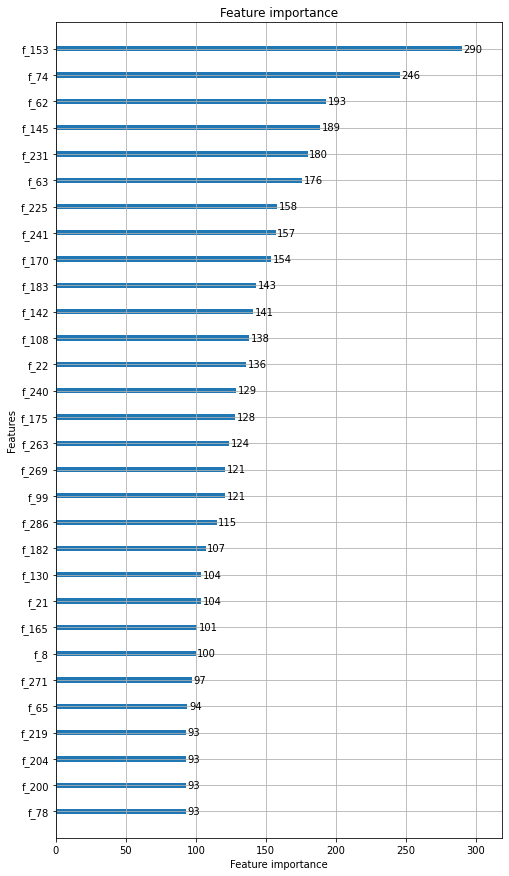

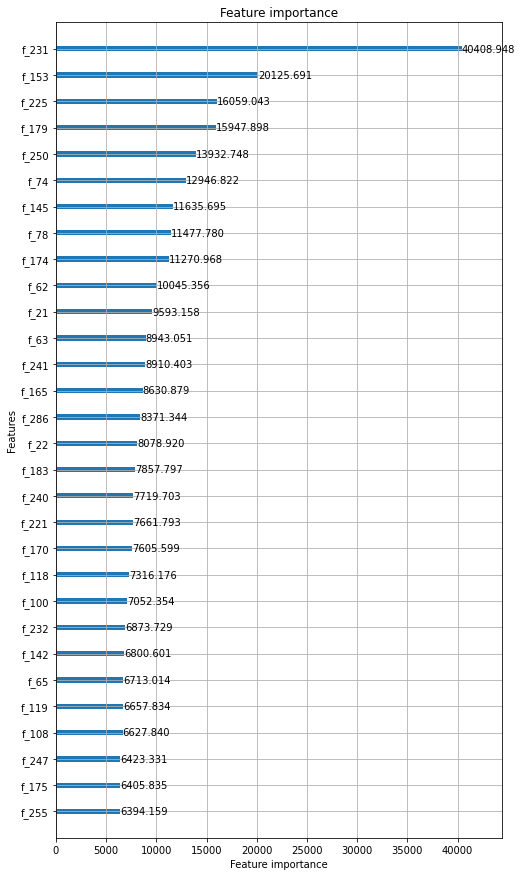

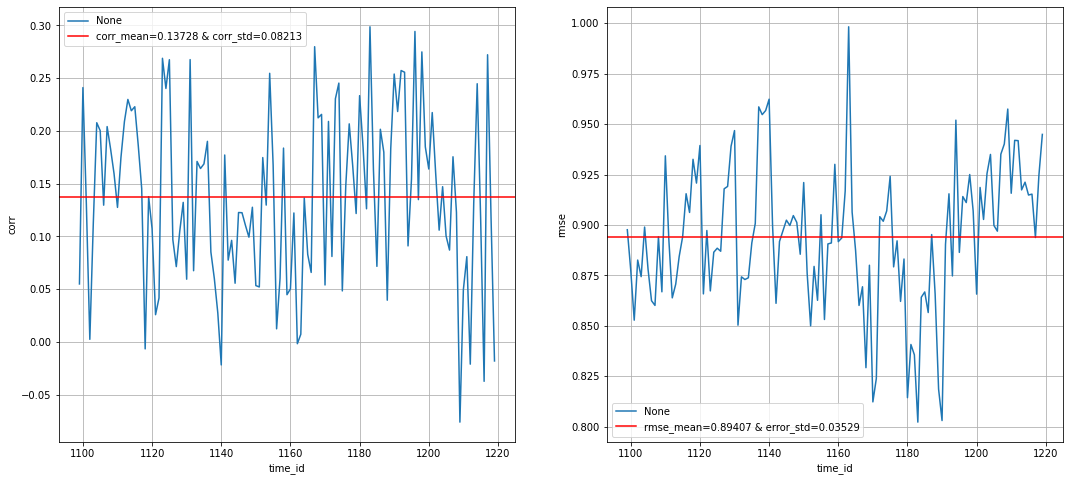

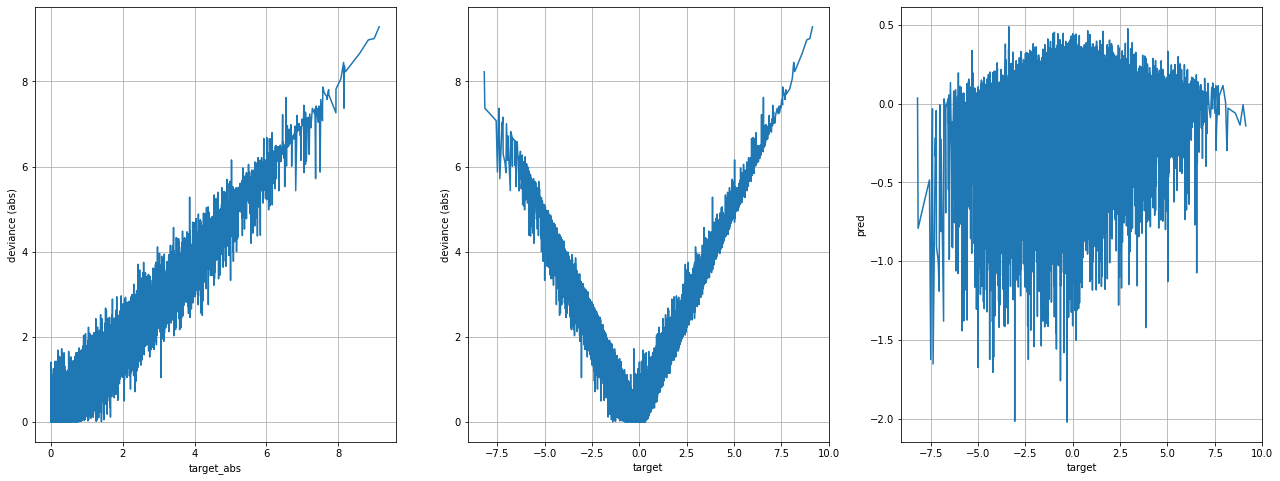

[LightGBM] [Info] Total Bins 76500
[LightGBM] [Info] Number of data points in the train set: 2364296, number of used features: 300
[LightGBM] [Info] Start training from score -0.024609
[20]	valid_0's rmse: 0.906487	valid_0's pearsonr: 0.110268
[40]	valid_0's rmse: 0.904979	valid_0's pearsonr: 0.116853
[60]	valid_0's rmse: 0.90421	valid_0's pearsonr: 0.120868
[80]	valid_0's rmse: 0.903631	valid_0's pearsonr: 0.12471
[100]	valid_0's rmse: 0.903185	valid_0's pearsonr: 0.12783
[120]	valid_0's rmse: 0.902826	valid_0's pearsonr: 0.130315
[140]	valid_0's rmse: 0.902478	valid_0's pearsonr: 0.132825
[160]	valid_0's rmse: 0.902207	valid_0's pearsonr: 0.134552
[180]	valid_0's rmse: 0.902017	valid_0's pearsonr: 0.135584
[200]	valid_0's rmse: 0.901902	valid_0's pearsonr: 0.136082
[220]	valid_0's rmse: 0.901837	valid_0's pearsonr: 0.136243
[240]	valid_0's rmse: 0.901695	valid_0's pearsonr: 0.137144
[260]	valid_0's rmse: 0.901548	valid_0's pearsonr: 0.138125
[280]	valid_0's rmse: 0.901466	valid_0's p

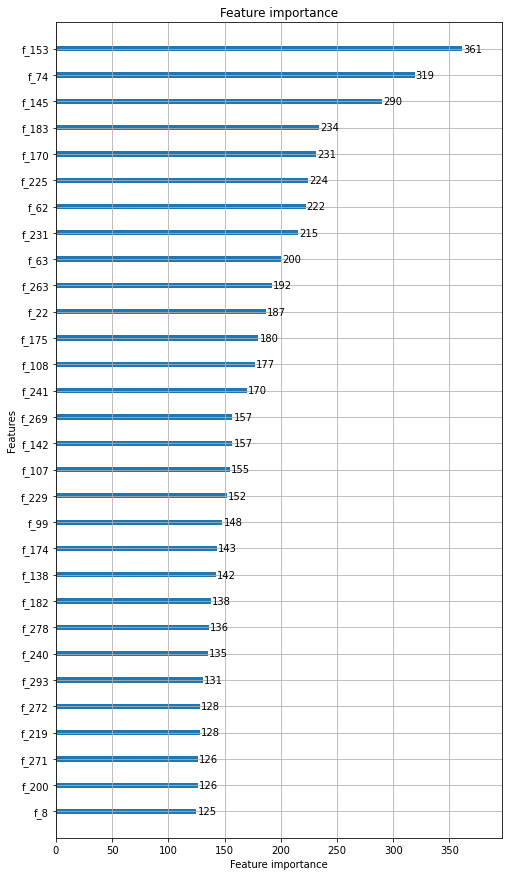

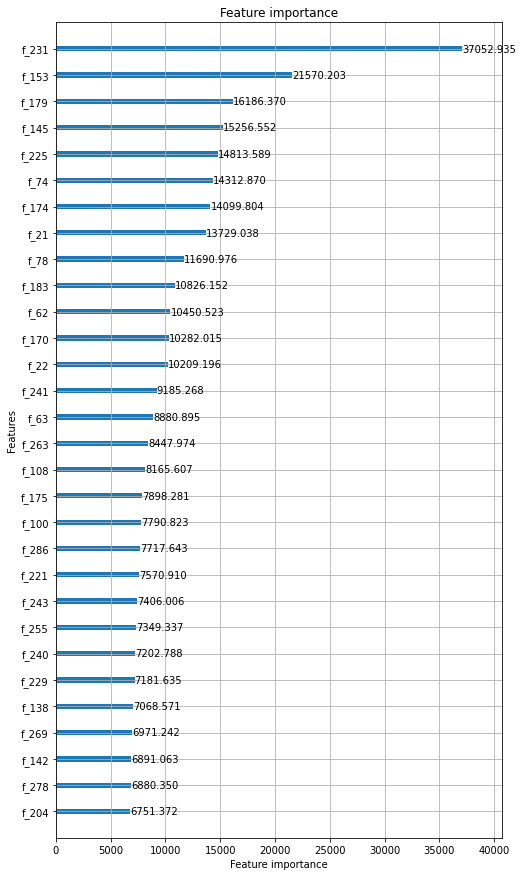

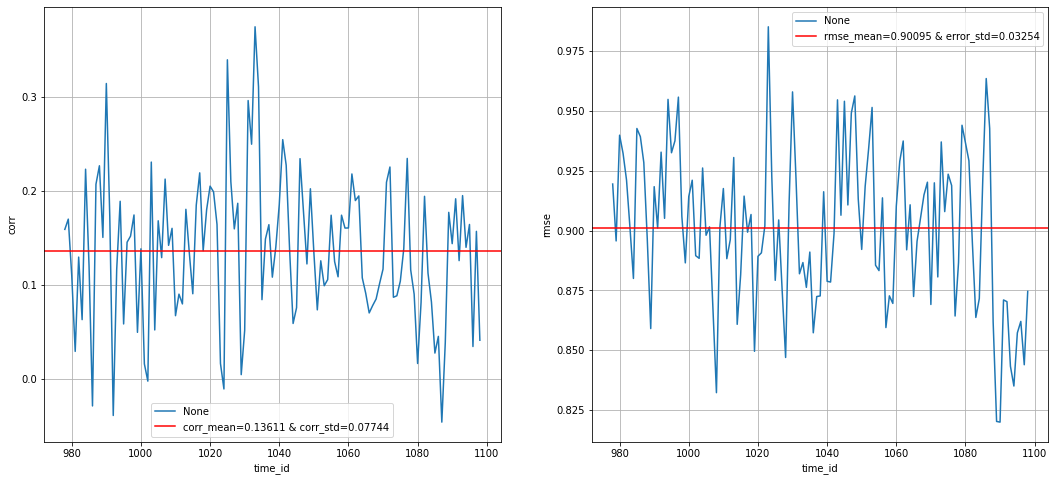

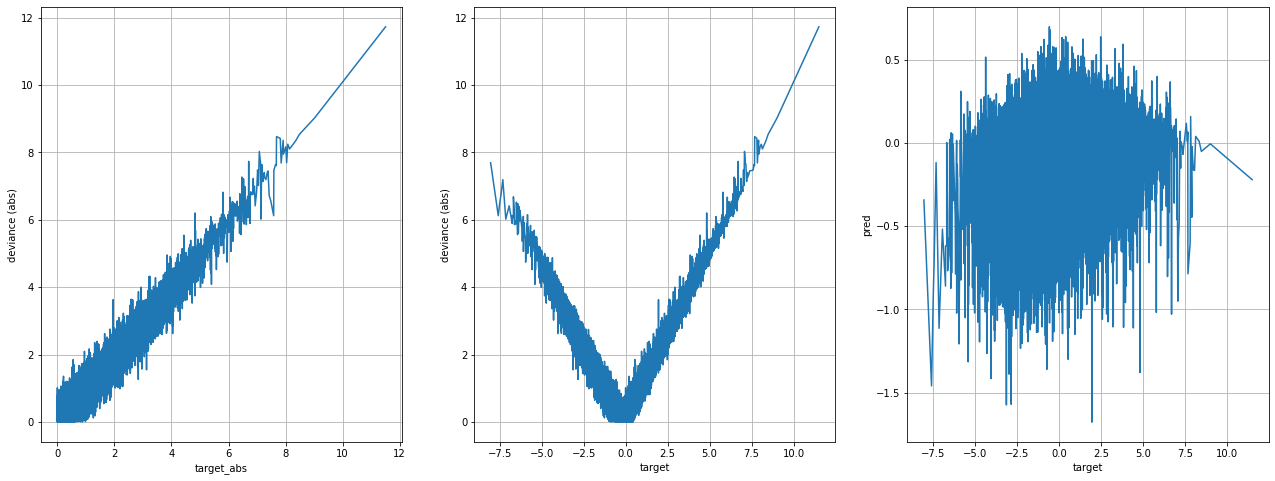

[LightGBM] [Info] Total Bins 76500
[LightGBM] [Info] Number of data points in the train set: 1995404, number of used features: 300
[LightGBM] [Info] Start training from score -0.026871
[20]	valid_0's rmse: 0.940605	valid_0's pearsonr: 0.0949466
[40]	valid_0's rmse: 0.939435	valid_0's pearsonr: 0.101518
[60]	valid_0's rmse: 0.938853	valid_0's pearsonr: 0.105263
[80]	valid_0's rmse: 0.938427	valid_0's pearsonr: 0.108701
[100]	valid_0's rmse: 0.93792	valid_0's pearsonr: 0.113317
[120]	valid_0's rmse: 0.937601	valid_0's pearsonr: 0.115917
[140]	valid_0's rmse: 0.937302	valid_0's pearsonr: 0.11842
[160]	valid_0's rmse: 0.937023	valid_0's pearsonr: 0.12069
[180]	valid_0's rmse: 0.936793	valid_0's pearsonr: 0.122514
[200]	valid_0's rmse: 0.936654	valid_0's pearsonr: 0.123524
[220]	valid_0's rmse: 0.936402	valid_0's pearsonr: 0.125572
[240]	valid_0's rmse: 0.93629	valid_0's pearsonr: 0.126411
[260]	valid_0's rmse: 0.936079	valid_0's pearsonr: 0.128153
[280]	valid_0's rmse: 0.93603	valid_0's pe

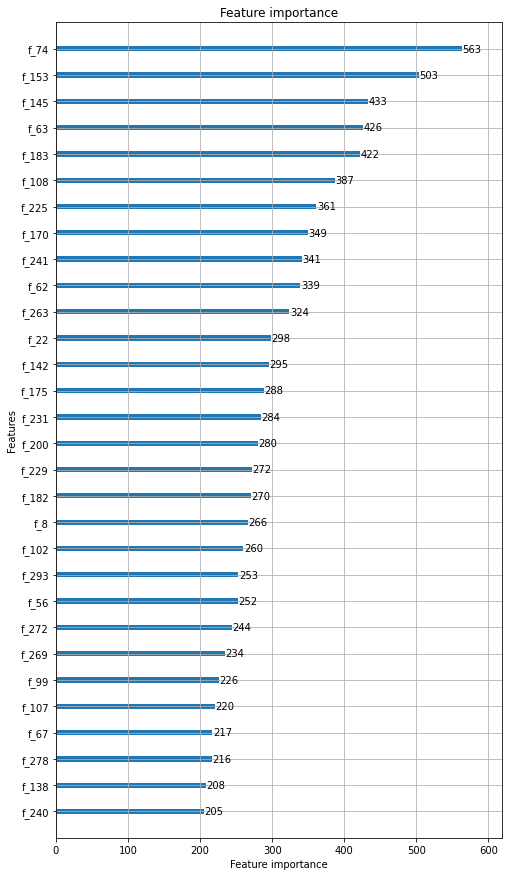

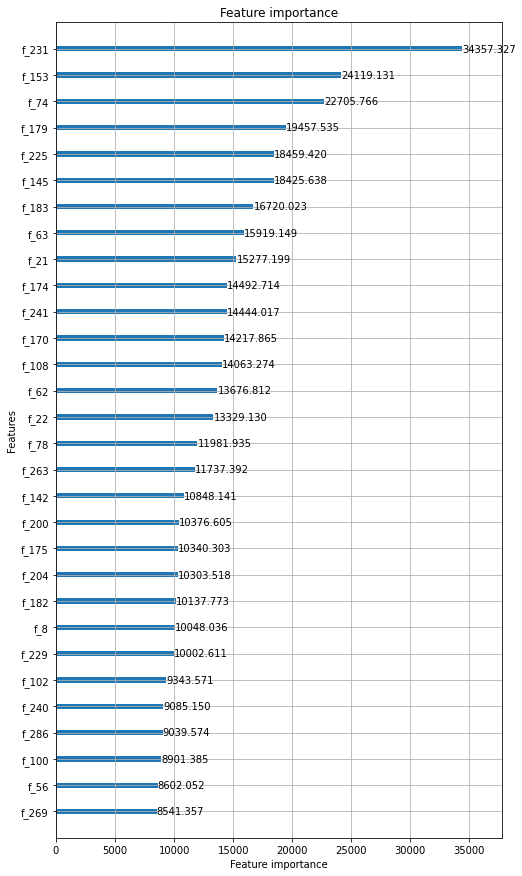

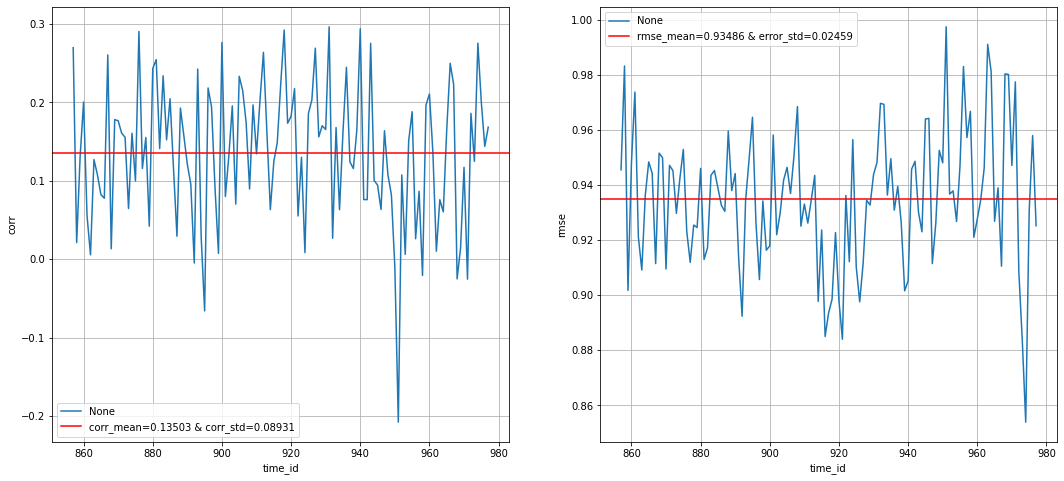

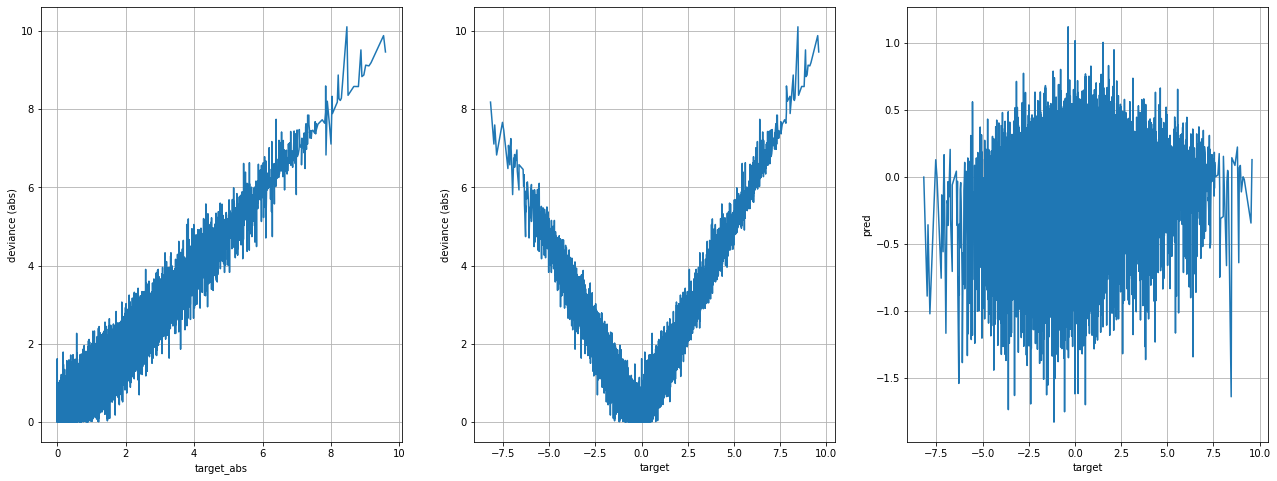

n_iterations: 367


In [10]:
pretrain = True
metrics = {"corr_mean":list(), "corr_std":list(), "error_mean":list(), "error_std":list(),}

if pretrain:
    
    models = list()

    for train_idx,valid_idx in splits:

        train_dset = lgb.Dataset(
            data=features.loc[train_idx,:],
            label=target.loc[train_idx,"target"].values,
            free_raw_data=True
        )
        valid_dset = lgb.Dataset(
            data=features.loc[valid_idx,:],
            label=target.loc[valid_idx,"target"].values,
            free_raw_data=True
        )
        es_callback = lgb.early_stopping(stopping_rounds=50, first_metric_only=False, verbose=False)
        log_callback = lgb.log_evaluation(period=20,)

        model = lgb.train(
            params=model_params,
            train_set=train_dset,
            num_boost_round=3000,
            valid_sets=[valid_dset,],
            feval=pearsonr,
            callbacks=[es_callback,log_callback],
        )
        models.append(model)

        lgb.plot_importance(model, figsize=(8,15), importance_type="split", max_num_features=30)
        lgb.plot_importance(model, figsize=(8,15), importance_type="gain", max_num_features=30)
        plt.show()
        
        # residual analysis on oof predictions
        oof = target.loc[valid_idx,:].copy()
        oof["time_id"] = time.loc[valid_idx,"time_id"]
        oof["pred"] = model.predict(features.loc[valid_idx,:])
        oof["target_abs"] = oof.eval("abs(target)")
        oof["dev"] = oof.eval("abs(target-pred)")

        corrs = oof.groupby("time_id").apply(lambda x: stats.pearsonr(x.target, x.pred)[0])
        corr_mean = corrs.mean()
        corr_std = corrs.std()
        error = oof.groupby("time_id").apply(lambda x: np.sqrt(np.mean((x.target-x.pred)**2)))
        error_mean = error.mean()
        error_std = error.std()
        
        metrics["corr_mean"].append(corr_mean)
        metrics["corr_std"].append(corr_std)
        metrics["error_mean"].append(error_mean)
        metrics["error_std"].append(error_std)

        plt.figure(figsize=(18,8))
        plt.subplot(1,2,1)
        corrs.plot()
        plt.axhline(
            y=corr_mean, 
            color='r', 
            linestyle='-', 
            label=f"corr_mean={corr_mean:.5f} & corr_std={corr_std:.5f}"
        )
        plt.grid()
        plt.ylabel("corr")
        plt.legend(loc="best")
        ##
        plt.subplot(1,2,2)
        error.plot()
        plt.axhline(
            y=error_mean, 
            color='r', 
            linestyle='-', 
            label=f"rmse_mean={error_mean:.5f} & error_std={error_std:.5f}"
        )
        plt.grid()
        plt.ylabel("rmse")
        plt.legend(loc="best")
        plt.show()

        plt.figure(figsize=(22,8))
        ##
        plt.subplot(1,3,1)
        plt.plot(oof.sort_values("target_abs").target_abs.values, oof.sort_values("target_abs").dev.values)
        plt.xlabel("target_abs")
        plt.ylabel("deviance (abs)")
        plt.grid()
        ##
        plt.subplot(1,3,2)
        plt.plot(oof.sort_values("target").target.values, oof.sort_values("target").dev.values)
        plt.xlabel("target")
        plt.ylabel("deviance (abs)")
        plt.grid()
        ##
        plt.subplot(1,3,3)
        plt.plot(oof.sort_values("target").target.values, oof.sort_values("target").pred.values)
        plt.xlabel("target")
        plt.ylabel("pred")
        plt.grid()
        plt.show()
           
    n_iterations = int(np.mean([m.best_iteration for m in models]))
    
else:
    # best value previously found
    n_iterations = 550
    

print("n_iterations:", n_iterations)

In [11]:
metrics

{'corr_mean': [0.1372796528039464, 0.13610804751240393, 0.13502930684120348],
 'corr_std': [0.08212508296076933, 0.07743631937578897, 0.08931165127180875],
 'error_mean': [0.8940708904909476, 0.9009465716696086, 0.934856222445695],
 'error_std': [0.03529381480839596, 0.03254441463651344, 0.024593910261824423]}

In [12]:
# mean corr on validation
np.mean(metrics["corr_mean"])

0.13613900238585128

In [13]:
# mean rmse on validation
np.mean(metrics["error_mean"])

0.9099578948687504

***
## model training

[LightGBM] [Info] Total Bins 76500
[LightGBM] [Info] Number of data points in the train set: 3141410, number of used features: 300
[LightGBM] [Info] Start training from score -0.021092
[20]	training's rmse: 0.914024	training's pearsonr: 0.138612
[40]	training's rmse: 0.911326	training's pearsonr: 0.151824
[60]	training's rmse: 0.909505	training's pearsonr: 0.16322
[80]	training's rmse: 0.907935	training's pearsonr: 0.173856
[100]	training's rmse: 0.906501	training's pearsonr: 0.183859
[120]	training's rmse: 0.90514	training's pearsonr: 0.193243
[140]	training's rmse: 0.903839	training's pearsonr: 0.201709
[160]	training's rmse: 0.902744	training's pearsonr: 0.208529
[180]	training's rmse: 0.901623	training's pearsonr: 0.215677
[200]	training's rmse: 0.900465	training's pearsonr: 0.222619
[220]	training's rmse: 0.899467	training's pearsonr: 0.228377
[240]	training's rmse: 0.898543	training's pearsonr: 0.23363
[260]	training's rmse: 0.897623	training's pearsonr: 0.238804
[280]	training's

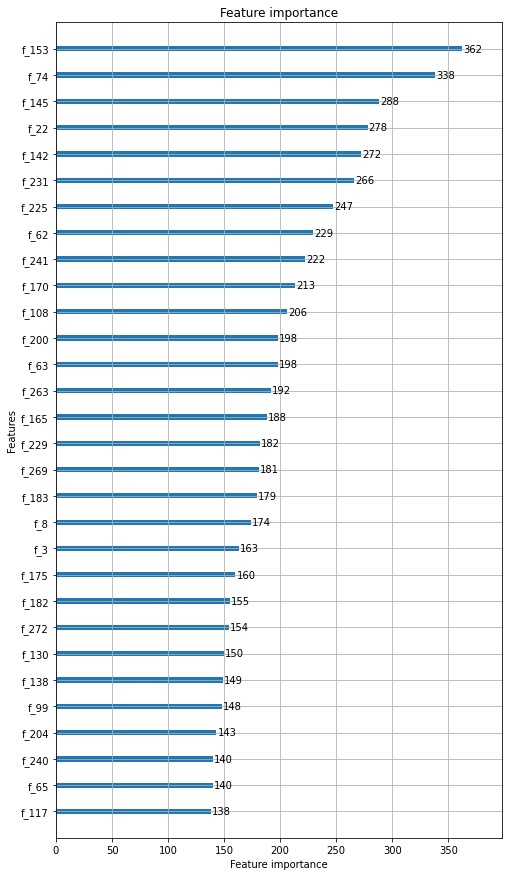

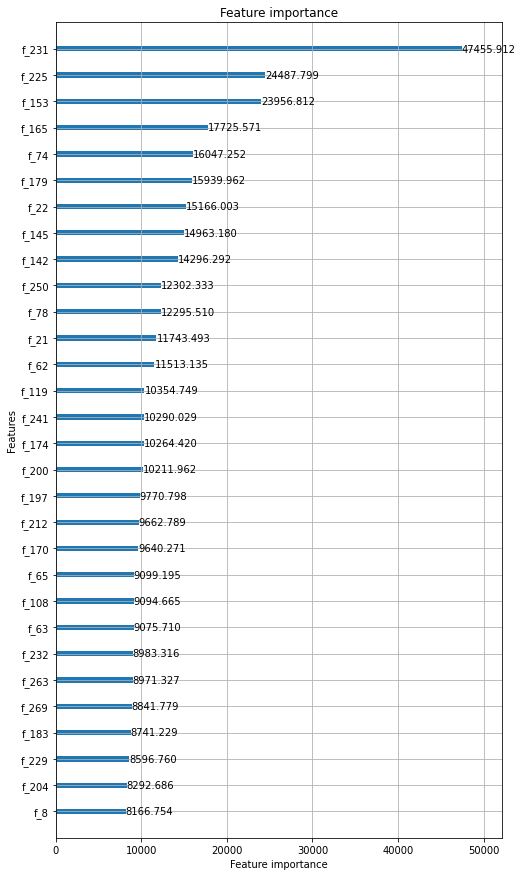

[LightGBM] [Info] Total Bins 76500
[LightGBM] [Info] Number of data points in the train set: 3141410, number of used features: 300
[LightGBM] [Info] Start training from score -0.021092
[20]	training's rmse: 0.913987	training's pearsonr: 0.139763
[40]	training's rmse: 0.911188	training's pearsonr: 0.1537
[60]	training's rmse: 0.909322	training's pearsonr: 0.164881
[80]	training's rmse: 0.907799	training's pearsonr: 0.174687
[100]	training's rmse: 0.906381	training's pearsonr: 0.184837
[120]	training's rmse: 0.905042	training's pearsonr: 0.194044
[140]	training's rmse: 0.903808	training's pearsonr: 0.201998
[160]	training's rmse: 0.902679	training's pearsonr: 0.208958
[180]	training's rmse: 0.90162	training's pearsonr: 0.215558
[200]	training's rmse: 0.900531	training's pearsonr: 0.222206
[220]	training's rmse: 0.899519	training's pearsonr: 0.228133
[240]	training's rmse: 0.898497	training's pearsonr: 0.23404
[260]	training's rmse: 0.89748	training's pearsonr: 0.239907
[280]	training's r

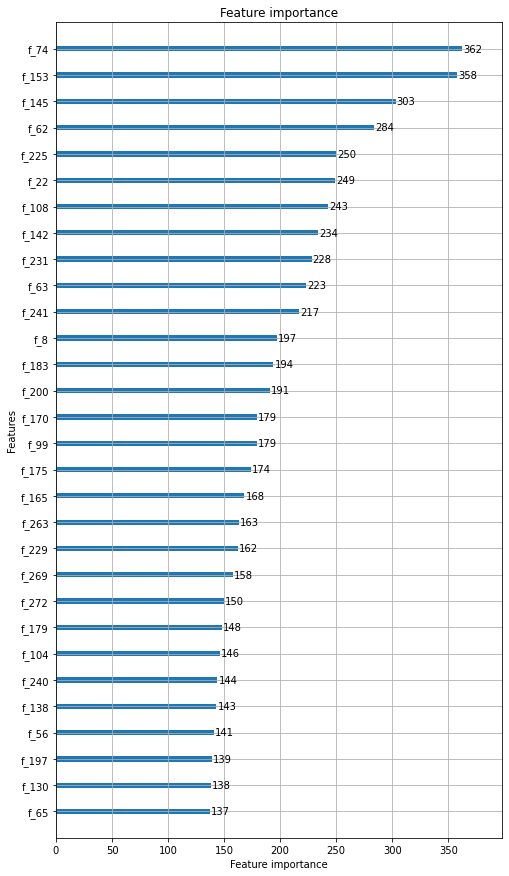

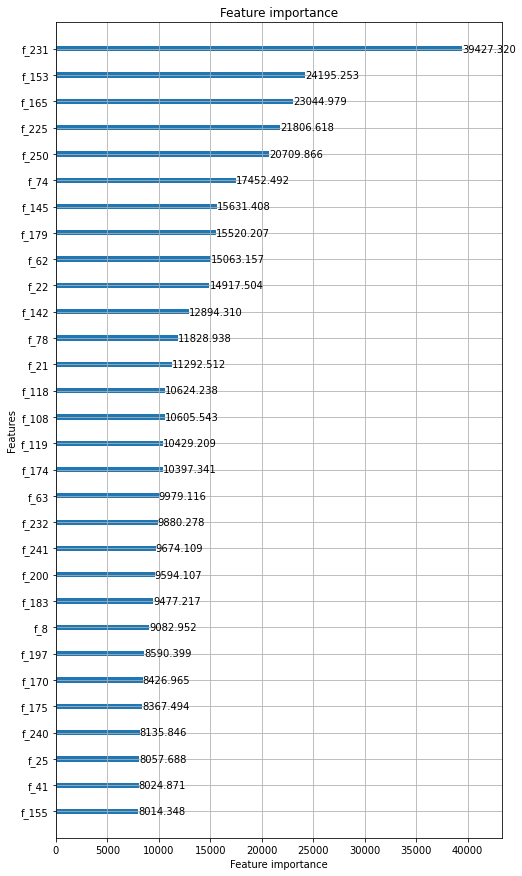

[LightGBM] [Info] Total Bins 76500
[LightGBM] [Info] Number of data points in the train set: 3141410, number of used features: 300
[LightGBM] [Info] Start training from score -0.021092
[20]	training's rmse: 0.914058	training's pearsonr: 0.139372
[40]	training's rmse: 0.911363	training's pearsonr: 0.151794
[60]	training's rmse: 0.909414	training's pearsonr: 0.164057
[80]	training's rmse: 0.907834	training's pearsonr: 0.174438
[100]	training's rmse: 0.90643	training's pearsonr: 0.184407
[120]	training's rmse: 0.905129	training's pearsonr: 0.193248
[140]	training's rmse: 0.903871	training's pearsonr: 0.201824
[160]	training's rmse: 0.9027	training's pearsonr: 0.208869
[180]	training's rmse: 0.901628	training's pearsonr: 0.215536
[200]	training's rmse: 0.900522	training's pearsonr: 0.222133
[220]	training's rmse: 0.899447	training's pearsonr: 0.228479
[240]	training's rmse: 0.898444	training's pearsonr: 0.234263
[260]	training's rmse: 0.897537	training's pearsonr: 0.239412
[280]	training's

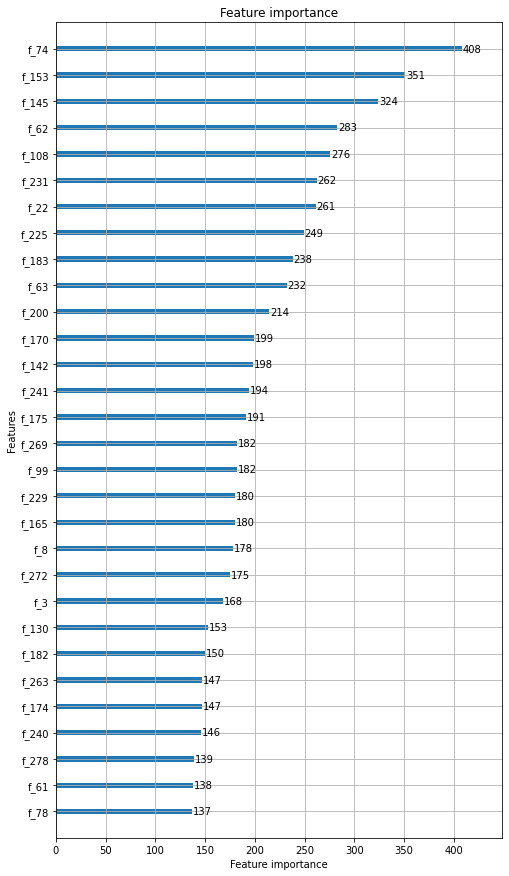

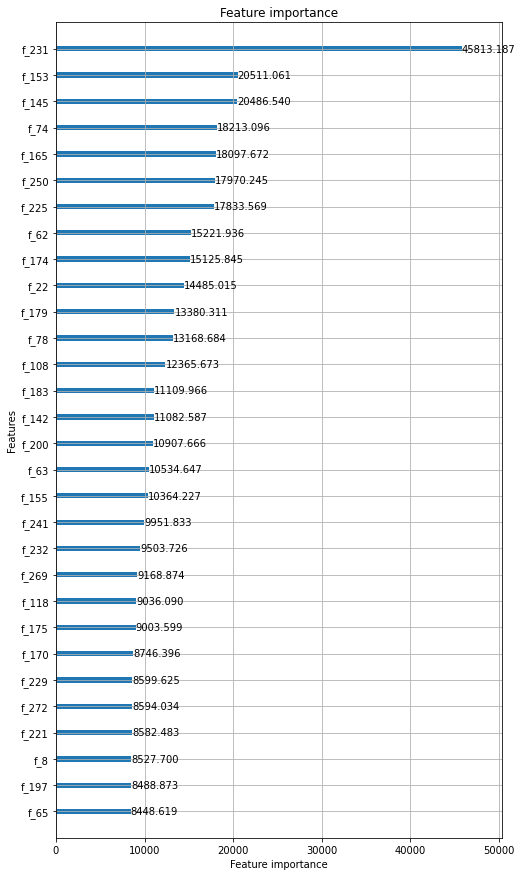

[LightGBM] [Info] Total Bins 76500
[LightGBM] [Info] Number of data points in the train set: 3141410, number of used features: 300
[LightGBM] [Info] Start training from score -0.021092
[20]	training's rmse: 0.913989	training's pearsonr: 0.138502
[40]	training's rmse: 0.911219	training's pearsonr: 0.152925
[60]	training's rmse: 0.909426	training's pearsonr: 0.16407
[80]	training's rmse: 0.907799	training's pearsonr: 0.175026
[100]	training's rmse: 0.906393	training's pearsonr: 0.184461
[120]	training's rmse: 0.905099	training's pearsonr: 0.19315
[140]	training's rmse: 0.903893	training's pearsonr: 0.201068
[160]	training's rmse: 0.902761	training's pearsonr: 0.208052
[180]	training's rmse: 0.901583	training's pearsonr: 0.215449
[200]	training's rmse: 0.900525	training's pearsonr: 0.221789
[220]	training's rmse: 0.899524	training's pearsonr: 0.227602
[240]	training's rmse: 0.898546	training's pearsonr: 0.233413
[260]	training's rmse: 0.897527	training's pearsonr: 0.239101
[280]	training'

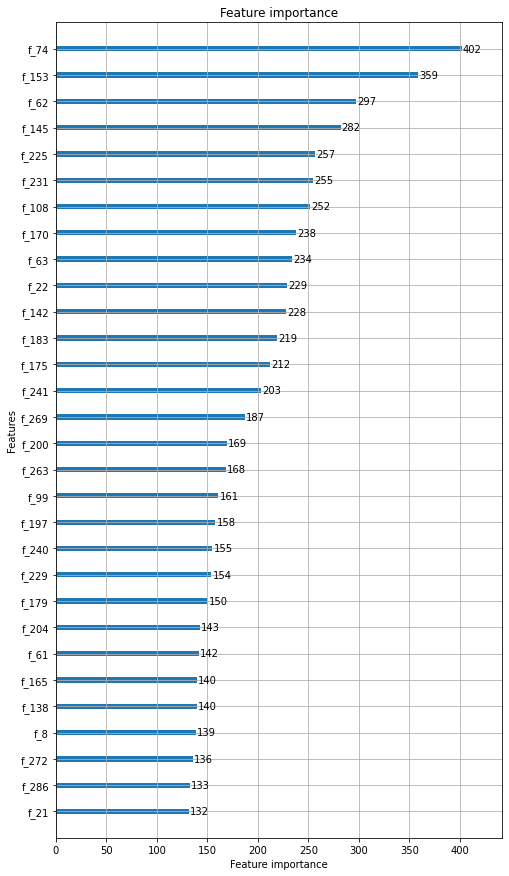

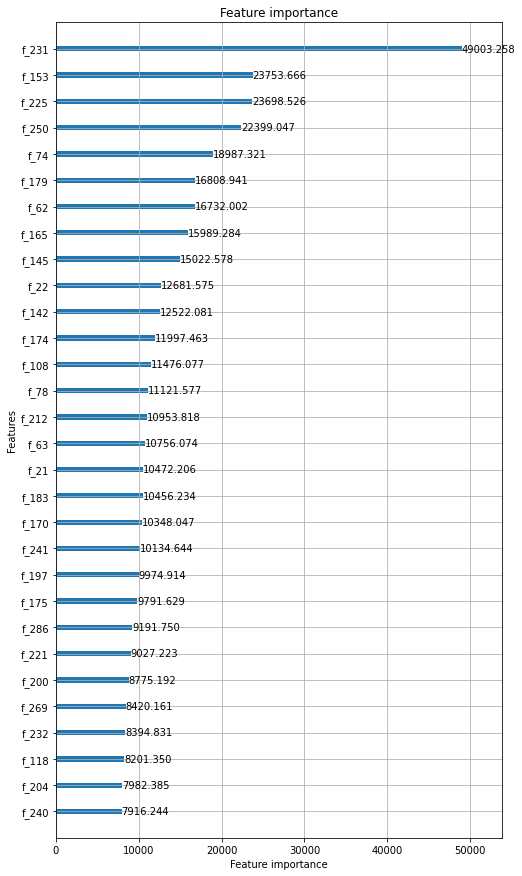

[LightGBM] [Info] Total Bins 76500
[LightGBM] [Info] Number of data points in the train set: 3141410, number of used features: 300
[LightGBM] [Info] Start training from score -0.021092
[20]	training's rmse: 0.913987	training's pearsonr: 0.140654
[40]	training's rmse: 0.911265	training's pearsonr: 0.152821
[60]	training's rmse: 0.909356	training's pearsonr: 0.164908
[80]	training's rmse: 0.907803	training's pearsonr: 0.175014
[100]	training's rmse: 0.906381	training's pearsonr: 0.184908
[120]	training's rmse: 0.905062	training's pearsonr: 0.193574
[140]	training's rmse: 0.903864	training's pearsonr: 0.201485
[160]	training's rmse: 0.902685	training's pearsonr: 0.208949
[180]	training's rmse: 0.90153	training's pearsonr: 0.216053
[200]	training's rmse: 0.900573	training's pearsonr: 0.221565
[220]	training's rmse: 0.899516	training's pearsonr: 0.228003
[240]	training's rmse: 0.898468	training's pearsonr: 0.234178
[260]	training's rmse: 0.89746	training's pearsonr: 0.239961
[280]	training'

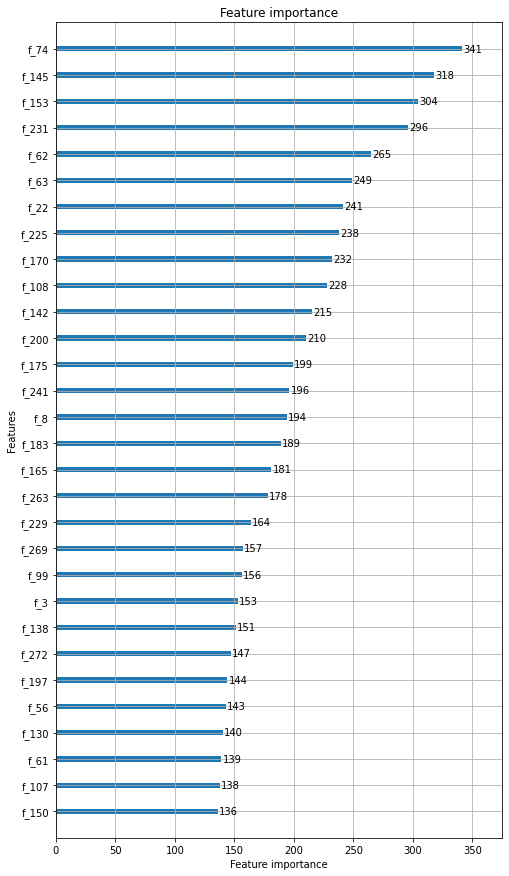

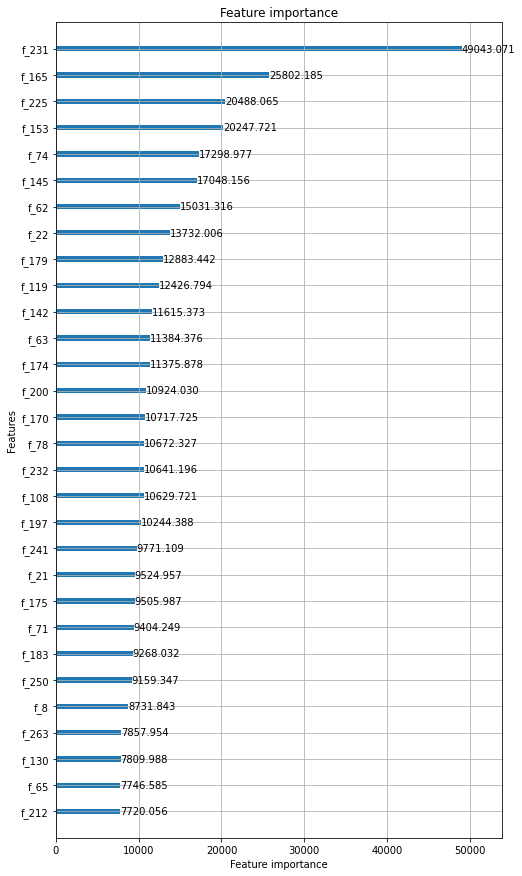

In [17]:
seeds = [2,7,11,19,23]
models = list()

train_dset = lgb.Dataset(
    data=features,
    label=target.target.values,
    free_raw_data=True
)

for seed in seeds:
    _model_params = dict(model_params)
    _model_params["seed"] = seed
    
    log_callback = lgb.log_evaluation(period=20)
    
    model = lgb.train(
        params=_model_params,
        train_set=train_dset,
        num_boost_round=n_iterations,
        valid_sets=[train_dset,],
        feval=pearsonr,
        callbacks=[log_callback,]
    )
    models.append(model)

    lgb.plot_importance(model, figsize=(8,15), importance_type="split", max_num_features=30)
    lgb.plot_importance(model, figsize=(8,15), importance_type="gain", max_num_features=30)
    plt.show()

In [18]:
for seed,model in zip(seeds,models): 
    model.save_model(f"../ump-artifacts/lgbm-gbrt/lgbm-seed{seed}.txt")

***
## inference

In [19]:
if current_env == "kaggle":

    import ubiquant
    env = ubiquant.make_env()  
    iter_test = env.iter_test()
    
    features = [f"f_{i}" for i in range(300)]
    for (test_df, sample_prediction_df) in iter_test:  
        preds = [model.predict(test_df[features]) for model in models]
        sample_prediction_df['target'] = np.mean(preds, axis=0)
        env.predict(sample_prediction_df) 
        display(sample_prediction_df)

***